# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
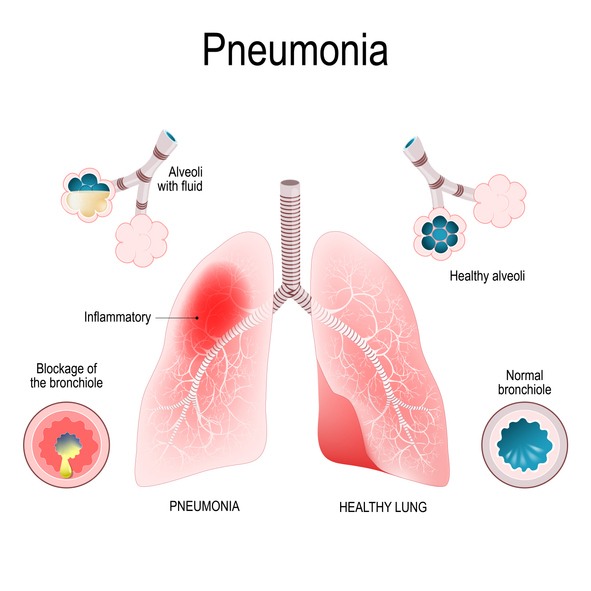

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./chest_xray/.DS_Store
./chest_xray/.DS_Store:Zone.Identifier
./chest_xray/train/.DS_Store
./chest_xray/train/.DS_Store:Zone.Identifier
./chest_xray/train/NORMAL/IM-0505-0001-0002.jpeg
./chest_xray/train/NORMAL/IM-0681-0001.jpeg:Zone.Identifier
./chest_xray/train/NORMAL/IM-0417-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1142-0001-0001.jpeg:Zone.Identifier
./chest_xray/train/NORMAL/NORMAL2-IM-1162-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0826-0001.jpeg:Zone.Identifier
./chest_xray/train/NORMAL/NORMAL2-IM-0908-0001.jpeg
./chest_xray/train/NORMAL/IM-0673-0001.jpeg:Zone.Identifier
./chest_xray/train/NORMAL/NORMAL2-IM-1351-0001.jpeg:Zone.Identifier
./chest_xray/train/NORMAL/NORMAL2-IM-1127-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0848-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-1059-0001.jpeg
./chest_xray/train/NORMAL/NORMAL2-IM-0661-0001.jpeg:Zone.Identifier
./chest_xray/train/NORMAL/IM-0612-0001-0001.jpeg:Zone.Identifier
./chest_xray/train/NORMAL/IM-0766-0001.jpeg:Zone.

# Importing the necessary libraries

In [2]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn
from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

# Loading the Dataset

In [4]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')


# Data Visualization & Preprocessing

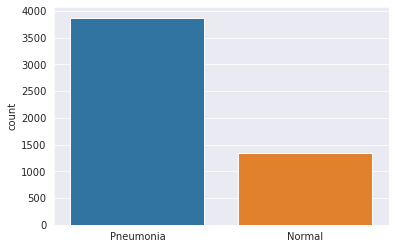

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

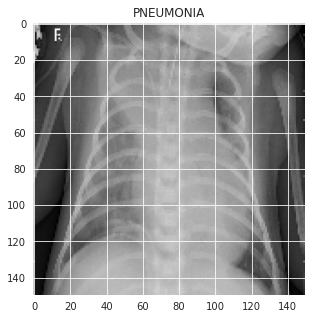

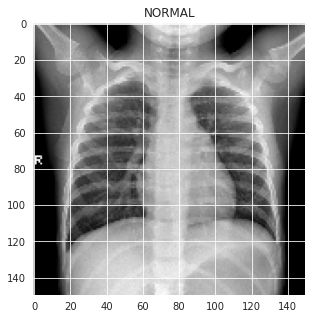

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)


x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


# PCA
# n_components = 0.1
# pca = PCA(n_components=n_components)

# 2. Fit PCA on the training data
# pca.fit(x_train)

# 3. Transform both the training and testing data using the fitted PCA
# x_train_pca = pca.transform(x_train)
# x_test_pca = pca.transform(x_test)

In [10]:


# linear 2:14 min 75.3%
# rbf 4:16 min 0.75%
# poly 5:55 min 0.63%
# without PCA

# https://ieeexplore.ieee.org/document/8869364
# model = SVC(C=3.5, kernel='rbf', gamma='auto')
# model.fit(x_train, y_train)

# # 5. Make predictions on the PCA-transformed testing data
# y_pred_pca = model.predict(x_test)

# # 6. Evaluate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred_pca)
# print(f"Accuracy: {accuracy}")

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [11]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


# datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [12]:
# try:
#     model = keras.models.load_model('model.keras')
#     model.summary()
# except Exception as e:
#     model = Sequential()
#     model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#     model.add(Dropout(0.1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
#     model.add(Flatten())
#     model.add(Dense(units = 128 , activation = 'relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(units = 1 , activation = 'sigmoid'))
#     model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
#     model.summary()

In [13]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [14]:
# try:
from tensorflow import keras
model = keras.models.load_model('model.keras')
model.summary()
# except Exception as e:
    #history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [15]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")
# model.save('model.keras')

624/624 [==============================] - 20s 32ms/sample - loss: 0.2363 - accuracy: 0.9135
Loss of the model is -  0.23625092552258417
624/624 [==============================] - 9s 15ms/sample - loss: 0.2363 - accuracy: 0.9135
Accuracy of the model is -  91.34615659713745 %


# Analysis after Model Training

Using layer: conv2d_4
Heatmap shape: (10, 10)
Heatmap min: 0.0, max: 1.0, mean: 0.25941622257232666


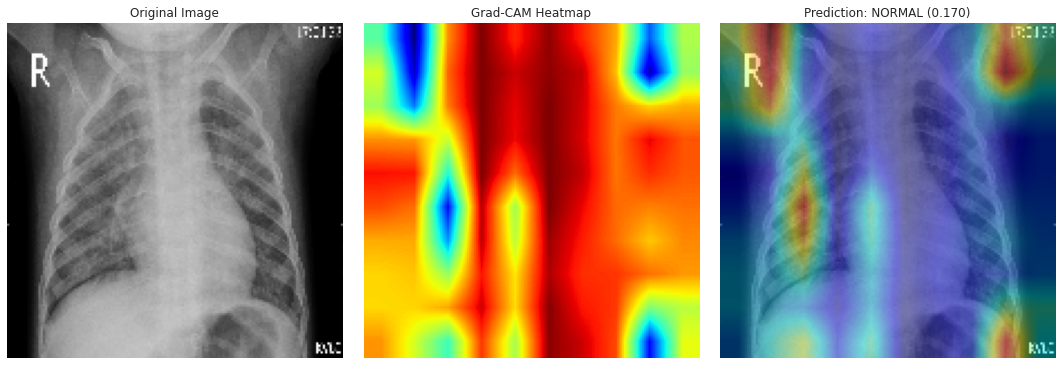

True label: PNEUMONIA
Predicted: NORMAL with confidence 0.1704
INCORRECT prediction


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt


def get_grad_cam(model, image, predicted_class=None, layer_name=None):
    """
    Generate Grad-CAM visualization for a given image and model.
    
    Args:
        model: Trained CNN model
        image: Single preprocessed image (normalized to [0,1])
        predicted_class: Optional integer class index. If None, uses the model's prediction
        layer_name: Optional name of the last convolutional layer. If None, tries to find it automatically
    
    Returns:
        Original image, heatmap, and superimposed image
    """
    # Make a copy of the image to prevent modifications to the original
    original_image = image.copy()
    
    # Ensure image has correct shape (add batch dimension if needed)
    if len(image.shape) == 3:
        image_array = np.expand_dims(image, axis=0)
    else:
        image_array = image
    
    # Find the last convolutional layer if not specified
    if layer_name is None:
        for layer in reversed(model.layers):
            # Check if it's a convolutional layer
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                print(f"Using layer: {layer_name}")
                break
    
    if layer_name is None:
        raise ValueError("Could not find a convolutional layer in the model")
    
    prediction = model.predict(image_array)
    predicted_probability = prediction[0][0]
    #krijgt probability tussen 0 en 1 voor wel/geen pneumonia
    predicted_class_idx = 1 if predicted_probability > 0.5 else 0
    
    # Create a model that outputs both the last conv layer and the final prediction
    last_conv_layer = model.get_layer(layer_name)
    grad_model = Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )
    
    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Cast image to float32
        conv_output, predictions = grad_model(tf.cast(image_array, tf.float32))
        
        # For binary classification with sigmoid
        # If predicted class is 1 (pneumonia), use the raw output
        # If predicted class is 0 (normal), use 1 - output to get gradients for "normal" class
        if predicted_class_idx == 1:
            class_score = predictions[0][0]
        else:
            class_score = 1 - predictions[0][0]
    
    # Get gradients of the class score with respect to the conv layer output
    gradients = tape.gradient(class_score, conv_output)
    
    # Global average pooling
    pooled_gradients = tf.reduce_mean(gradients, axis=(0, 1))
    
    # Multiply each channel in the feature map by its importance
    conv_output = conv_output[0]  # Remove batch dimension
    weighted_features = tf.multiply(conv_output, pooled_gradients)
    
    # Sum all weighted channels to create heatmap
    heatmap = tf.reduce_sum(weighted_features, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    
    heatmap_max = np.max(heatmap)
    if heatmap_max > 0:
        heatmap = heatmap / heatmap_max
    
    if len(original_image.shape) == 3:
        img_height, img_width = original_image.shape[0], original_image.shape[1]
    else:
        img_height, img_width = original_image.shape[1], original_image.shape[2]
    
    heatmap_resized = cv2.resize(heatmap, (img_width, img_height))
    
    heatmap_normalized = np.uint8(255 * heatmap_resized)
    
    if len(original_image.shape) == 3 and original_image.shape[2] == 1:
        # terug naar RGB
        img_display = np.squeeze(original_image)
        img_display = np.uint8(255 * img_display)
        img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2RGB)
    elif len(original_image.shape) == 3 and original_image.shape[2] == 3:
        img_display = np.uint8(255 * original_image)
    else:
        img_single = original_image[0] if len(original_image.shape) == 4 else original_image
        if img_single.shape[-1] == 1:
            img_display = np.squeeze(img_single)
            img_display = np.uint8(255 * img_display)
            img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2RGB)
        else:
            img_display = np.uint8(255 * img_single)
    
    # blend met 60/40 gewichten
    heatmap_normalized = 255 - heatmap_normalized
    colored_heatmap = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_display, 0.6, colored_heatmap, 0.4, 0)
    
    return img_display, heatmap_normalized, superimposed, predicted_class_idx, predicted_probability

def visualize_grad_cam(original, heatmap, superimposed, predicted_class_idx, predicted_prob, class_names=None):
    """
    Visualize Grad-CAM results
    """
    if class_names is None:
        class_names = ["NORMAL", "PNEUMONIA"]
    
    class_name = class_names[predicted_class_idx]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # de xray scan
    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # heatmap
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis('off')
    
    # overelkaar
    axes[2].imshow(superimposed)
    axes[2].set_title(f"Prediction: {class_name} ({predicted_prob:.3f})")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

def test_on_single_image(model, image, true_class=None, class_names=None):
    """
    Apply Grad-CAM on a single image
    
    Args:
        model: Trained model
        image: Single image (normalized)
        true_class: Optional true class index for comparison
        class_names: Optional list of class names
    """
    if class_names is None:
        class_names = ["NORMAL", "PNEUMONIA"]
    
    # Get Grad-CAM results
    original, heatmap, superimposed, pred_class, pred_prob = get_grad_cam(model, image)
    
    # Visualize
    visualize_grad_cam(original, heatmap, superimposed, pred_class, pred_prob, class_names)
    
    # Print prediction vs ground truth if available
    if true_class is not None:
        print(f"True label: {class_names[true_class]}")
        print(f"Predicted: {class_names[pred_class]} with confidence {pred_prob:.4f}")
        print(f"{'CORRECT' if true_class == pred_class else 'INCORRECT'} prediction")

# Usage example
idx = 8  # Choose an image from your test set
test_image = x_test[idx]
true_label = 1
# Test Grad-CAM

try:
    test_on_single_image(model, test_image, true_class=int(true_label))
except Exception as e:
    print(f"error: {e}")


In [17]:
# epochs = [i for i in range(12)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# fig.set_size_inches(20,10)

# ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
# ax[0].set_title('Training & Validation Accuracy')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Accuracy")

# ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
# ax[1].set_title('Testing Accuracy & Loss')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Training & Validation Loss")
# plt.show()

In [18]:
# predictions = model.predict(x_test)
# predicted_classes = (predictions > 0.5).astype("int32")
# predicted_classes[:15]

In [19]:
# print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

In [20]:
# cm = confusion_matrix(y_test, predicted_classes)
# cm


In [21]:
# cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

# plt.figure(figsize=(10, 10))
# sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1,
#          annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix for Pneumonia Classification")
# plt.show()


- There is a bug in the Seaborn library version being used (`0.12.0`), which causes only the top value to be filled in.  
- Unfortunately, the Seaborn library can't be updated since it conflicts with other dependencies.  
- So there is no quick fix for this — only creating the plot in a separate file using the up-to-date Seaborn library.  
- Run `pip install seaborn --upgrade` in a different environment to create a proper plot.


In [22]:
# correct = np.nonzero(predictions == y_test)[0]
# incorrect = np.nonzero(predictions != y_test)[0]
# print(incorrect)

**Some of the Correctly Predicted Classes**

In [23]:
# i = 0
# for c in correct[:6]:
#     plt.subplot(3,2,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
#     plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
#     plt.tight_layout()
#     i += 1

**Some of the Incorrectly Predicted Classes**

In [24]:
# i = 0
# for c in incorrect[:6]:
#     plt.subplot(3,2,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
#     plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
#     plt.tight_layout()
#     i += 1